# Human Activity Recognition for Healthy Lifestyle Monitoring (Team 44)

## Overview


In [6]:
# Import required libraries
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



## 0) Data Collection

## 1) Data Loading

### Raw Data Management

The raw dataset is organized into activity folders. Each folder corresponds to **one trial of one activity performed by one student**.  

Naming of Data  
- Format: **`{Activity}_{trial}_{student}`**  
- Example: `Sit_1_Student1`  

The dataset includes **five fundamental activities**, each represented by a short folder name:

- **Sitting Down** → `Sit`  

- **Standing Up** → `Stand`  

- **Walking** → `Walking`  

- **Running** → `Running`  

- **Climbing Stairs** → `Stairs`  

For our analysis, we will use only the calibrated sensor files for the following sensors of interest:
- `Accelerometer.csv` → linear acceleration (x, y, z)  
- `Gravity.csv` → device orientation relative to gravity (x, y, z)  
- `Gyroscope.csv` → angular velocity (x, y, z)  

In [24]:
# ----------------------------------------------------------
# Function to load raw data
# ----------------------------------------------------------
def load_raw_data(root_dir, sensors=("Accelerometer", "Gravity", "Gyroscope")):
    """
    Load raw sensor data into a nested dictionary.

    Structure:
        data[activity][trial][student][sensor] = DataFrame

    Folder naming convention:
        "{Activity}_{trial}_{student}"
        e.g. "Sit_1_Student1"
    """

    data = {}

    # Iterate over all folders in root_dir
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        # Match folder name pattern
        match = re.match(r"([A-Za-z]+)_(\d+)_([A-Za-z0-9]+)", folder)

        activity, trial, student = match.groups()

        # Initialize nested dictionary structure
        data.setdefault(activity, {}).setdefault(trial, {}).setdefault(student, {})

        # Load each sensor file if available
        for sensor in sensors:
            file_path = os.path.join(folder_path, f"{sensor}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                data[activity][trial][student][sensor.lower()] = df
            else:
                print(f"[load_raw_data] Missing {file_path}")

    return data

In [25]:
# Load the raw data 
data = load_raw_data("Raw Data")

### Loading the data

The `load_raw_data` function organizes the dataset into a **nested dictionary** with the following structure:

**`data[activity][trial][student][sensor] = DataFrame`**

#### Hierarchy Breakdown
- **activity** → type of movement (`"Sit"`, `"Stand"`, `"Walking"`, `"Stairs"`, `"Running"`)  
- **trial** → trial number for that activity (e.g., `"1"`, `"2"`)  
- **student** → participant identifier (`"Student1"`, `"Student2"`)  
- **sensor** → one of the chosen sensors (`"accelerometer"`, `"gyroscope"`, `"gravity"`)  

Each sensor entry is stored as a Pandas DataFrame containing the raw time-series data.

For example, the accelerometer data for Student1 performing Sit activity, trial 1 can be accessed by:

In [26]:
data["Sit"]["1"]["Student1"]["accelerometer"]

,time,seconds_elapsed,z,y,x
0,1759157635439398700,0.046399,-0.018303,0.185763,-0.340953
1,1759157635449457000,0.056457,-0.024306,0.200625,-0.232246
2,1759157635459516000,0.066516,-0.006346,0.178468,-0.168432
3,1759157635469573600,0.076574,-0.053671,0.133353,-0.122252
4,1759157635479632000,0.086632,-0.104921,0.097954,-0.082920
...,...,...,...,...,...
525,1759157640719951400,5.326951,0.121495,0.310511,0.033830
526,1759157640730009600,5.337010,-0.081366,0.240393,0.168840
527,1759157640740067600,5.347068,-0.059322,0.012517,0.094556
528,1759157640750125300,5.357125,0.230433,-0.295023,0.065098


This data can be visualised by plotting a graph.

In [ ]:
# ----------------------------------------------------------
# Function to plot raw sensor signals (x, y, z) over time
# ----------------------------------------------------------
def plot_sensors(sensor_data, activity_name="Activity"):
    """
    Plots x, y, z vs seconds_elapsed for Accelerometer, Gravity, and Gyroscope in separate subplots
    """

    # Create 3 subplots (one per sensor), share x-axis (time)
    fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
    fig.suptitle(f"{activity_name} Sensor Data", fontsize=16)

    # Loop through each sensor and plot x, y, z signals
    for ax, (sensor_name, df) in zip(axes, sensor_data.items()):
        ax.plot(df['seconds_elapsed'], df['x'], label='x')
        ax.plot(df['seconds_elapsed'], df['y'], label='y')
        ax.plot(df['seconds_elapsed'], df['z'], label='z')

        # Label subplot with sensor name (e.g., Accelerometer, Gravity, Gyroscope)
        ax.set_ylabel(sensor_name.capitalize())
        ax.legend()
        
    # Label x-axis (shared for all subplots)
    axes[-1].set_xlabel("Seconds Elapsed")
    plt.show()

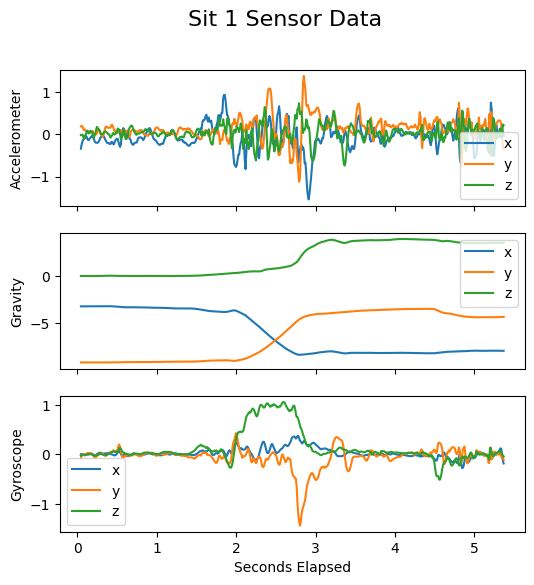

In [29]:
# ----------------------------------------------------------
# Visualize raw signals for Sit 1, Student 1
# ----------------------------------------------------------

# Extract accelerometer, gravity, and gyroscope dataframes
sit1_acc = data["Sit"]["1"]["Student1"]["accelerometer"]
sit1_grav = data["Sit"]["1"]["Student1"]["gravity"]
sit1_gyr = data["Sit"]["1"]["Student1"]["gyroscope"]

# Plot the 3 sensors together for Sit_1_Student1
plot_sensors(
    {
        "accelerometer": sit1_acc,
        "gravity": sit1_grav,
        "gyroscope": sit1_gyr
    },
    activity_name="Sit 1")

## 2) Preprocessing

### 2.1) Data Preprocessing

In this project, the preprocessing includes several key steps:  
- **Time Synchronization** → align all sensor signals to a common time base  
- **Trimming** → remove non-activity or idle periods from the recordings  
- **Windowing** → segment continuous signals into fixed-length windows for analysis and feature extraction  



In [ ]:
# Data Preprocessing parameters



#### 2.1.1 Time Synchronization

Although all sensor data was recorded at **100 Hz**, the actual timestamps may vary slightly between sensors and participants, meaning their signals are not perfectly aligned.  

A **time synchronization technique** was applied to align all signals to a common timeline, ensuring values from different sensors represent the same moment. With synchronized timestamps, the three sensors data are merged into a single dataset per trial.  



This is done with the code below.  
In summary, we:  
1. Clean each sensor dataset (numeric conversion, sorting, removing duplicates).  
2. Align all three sensors on a uniform 100 Hz timeline.  
3. Interpolate missing values.  
4. Discard values not on the timeline.  
5. Merge them into one synchronized dataset per trial and save.

In [ ]:
# ----------------------------------------------------------
# Function to synchronize the loaded data, and save
# ----------------------------------------------------------

def build_synchronized_dataset(
    loaded_data,
    out_dir = "Synchronized Data",
    fs = 100.0,
    float_fmt = "%.2f"
):
    """
    Synchronize the loaded data to a common timeline at `fs` Hz,
    save CSVs to disk, and return a nested dict:

        synced[activity][trial][student] = DataFrame
            columns: seconds_elapsed, acc_x/y/z, grav_x/y/z, gyro_x/y/z
    """

    REQUIRED_SENSORS = ("accelerometer", "gravity", "gyroscope")

    # ---------------------------
    # Helpers
    # ---------------------------

    def clean(df: pd.DataFrame) -> pd.DataFrame:
        """ Ensure numeric, sort by time, drop invalid/duplicate rows."""
        # Drop the time column
        df = df.drop(columns="time")
        # Ensure numeric
        df["seconds_elapsed"] = pd.to_numeric(df["seconds_elapsed"], errors="coerce")
        for c in df.columns:
            if c != "seconds_elapsed":
                df[c] = pd.to_numeric(df[c], errors="coerce")
        # Drop na and duplicates
        df = df.dropna(subset=["seconds_elapsed"]).sort_values("seconds_elapsed")
        df = df.drop_duplicates(subset=["seconds_elapsed"])
        return df
    
    def add_prefix(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
        """Prefix feature columns (e.g., x,y,z) with sensor tag (acc_, grav_, gyro_)."""
        return df.rename(columns={c: f"{prefix}_{c.lower()}" for c in df.columns if c != "seconds_elapsed"})


    def process_one_trial(sensor_dict: dict) -> pd.DataFrame:
        """Align accelerometer, gravity, and gyroscope signals to a uniform timeline."""
        # Check required sensors are present
        for r in REQUIRED_SENSORS:
            if r not in sensor_dict:
                raise FileNotFoundError(f"Missing sensor '{r}'")

        # Clean and rename columns for clarity
        acc  = add_prefix(clean(sensor_dict["accelerometer"].copy()), "acc")
        grav = add_prefix(clean(sensor_dict["gravity"].copy()), "grav")
        gyro = add_prefix(clean(sensor_dict["gyroscope"].copy()), "gyro")

        # Merge all sensors on time
        merged = (
            acc.merge(grav, on="seconds_elapsed", how="outer")
               .merge(gyro, on="seconds_elapsed", how="outer")
               .sort_values("seconds_elapsed")
               .reset_index(drop=True)
        )

        # Identify common overlapping time window
        start = max(acc["seconds_elapsed"].min(), grav["seconds_elapsed"].min(), gyro["seconds_elapsed"].min())
        end   = min(acc["seconds_elapsed"].max(), grav["seconds_elapsed"].max(), gyro["seconds_elapsed"].max())
        if not (end > start): 
            return pd.DataFrame()

        # Generate exact timeline at fs Hz
        start_tick, end_tick = int(np.ceil(start * fs)), int(np.floor(end * fs))
        timeline = np.arange(start_tick, end_tick + 1) / fs

        # Reindex and interpolate onto uniform timeline
        union_index = np.unique(np.concatenate([merged["seconds_elapsed"].values, timeline]))
        union_df = merged.set_index("seconds_elapsed").reindex(union_index).sort_index()
        num_cols = union_df.select_dtypes(include=[np.number]).columns
        union_df[num_cols] = union_df[num_cols].interpolate(method="linear", limit_direction="both")

        # Keep only target timeline values
        aligned = union_df.reset_index().rename(columns={"index": "seconds_elapsed"})
        aligned = aligned[aligned["seconds_elapsed"].isin(timeline)].reset_index(drop=True)

        # Round timestamps to exact multiples of fs
        aligned["seconds_elapsed"] = np.round(aligned["seconds_elapsed"] * fs).astype(int) / fs
        return aligned

    os.makedirs(out_dir, exist_ok=True)
    synced = {}

    # Iterate over activities, trials, and students
    for activity, trials in loaded_data.items():
        for trial, students in trials.items():
            for student, sensor_dict in students.items():
                folder_name = f"{activity}_{trial}_{student}"
                out_trial_dir = os.path.join(out_dir, folder_name)
                os.makedirs(out_trial_dir, exist_ok=True)

                # Build synchronized dataset for this trial
                try:
                    aligned = process_one_trial(sensor_dict)
                    if aligned.empty: 
                        continue
                except Exception:
                    continue

                # Save synchronized CSV
                aligned.to_csv(os.path.join(out_trial_dir, "sensor_data.csv"), index=False, float_format=float_fmt)

                # Store in nested dict
                synced.setdefault(activity, {}).setdefault(trial, {})[student] = aligned

    return synced

The folder structure mirrors the raw dataset:  
- **Folder name**: `{Activity}_{trial}_{student}`  
- **File**: `sensor_data.csv` → contains aligned and merged accelerometer, gravity, and gyroscope data.  

The synchronized data is saved **separately from the raw data** to ensure that the original recordings remain untouched.  
This separation prevents accidental overwriting, keeps the preprocessing pipeline reproducible, and makes it clear which files are raw and which are preprocessed.  

In [55]:
# Apply synchronization
synced = build_synchronized_dataset(
    loaded_data=data,
    out_dir="Synchronized Data",
    fs=100.0,
    float_fmt="%.4f"
)


Apart from saving the synchronized files to disk, the function also returns a nested dictionary synced with the structure:
**`synced[activity][trial][student]`**

Its structure is the same as the raw data dictionary, but now each entry contains a single merged DataFrame with the synchronized accelerometer, gravity, and gyroscope signals.

For example, the synchronized data for Student1 performing Sit activity, trial 1 can be accessed by:

In [57]:
synced["Sit"]["1"]["Student1"]

,seconds_elapsed,acc_z,acc_y,acc_x,grav_z,grav_y,grav_x,gyro_z,gyro_y,gyro_x
0,0.05,-0.021304,0.193194,-0.286599,0.037914,-9.258764,-3.231755,-0.020207,-0.057970,-0.000377
1,0.06,-0.015326,0.189547,-0.200339,0.038969,-9.259231,-3.230402,-0.009920,-0.017987,-0.002837
2,0.07,-0.030008,0.155911,-0.145342,0.038763,-9.259413,-3.229883,-0.003485,0.002401,-0.007196
3,0.08,-0.079296,0.115654,-0.102586,0.037772,-9.259483,-3.229693,-0.001808,-0.001130,-0.013970
4,0.09,-0.100334,0.104005,-0.060578,0.036439,-9.259581,-3.229429,-0.004059,-0.009976,-0.018337
...,...,...,...,...,...,...,...,...,...,...
527,5.32,0.123579,0.315094,0.032262,3.586686,-4.372518,-8.011688,0.063295,0.005025,0.107669
528,5.33,0.020065,0.275452,0.101335,3.592112,-4.363776,-8.014022,0.047529,-0.019902,0.114815
529,5.34,-0.070344,0.126455,0.131698,3.599247,-4.358056,-8.013933,0.015532,-0.060127,0.048145
530,5.35,0.085555,-0.141253,0.079827,3.604284,-4.358200,-8.011592,-0.010594,-0.069782,-0.068237


#### 2.1.2 Trimming

In [ ]:
# Trimming parameters

start_offset_s 
duration_s
start_trim_s
end_trim_s
window_size_s

In [60]:
# Time columns 
TIME_COL = "seconds_elapsed"

def _crop_segment(df, start_offset_s, duration_s, hz=100.0):
    """
    Fixed-length slice by sample count (index-based), e.g., for Sit/Stand.
    Returns empty if the requested window cannot be satisfied exactly.
    """
    if df is None or df.empty:
        return df

    # Convert offset and duration from seconds to samples
    n_off = int(round(float(start_offset_s) * hz))
    n_win = int(round(float(duration_s) * hz))
    if n_off < 0 or n_win <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    start_idx = n_off
    end_idx = start_idx + n_win

     # If outside valid range, return empty
    if start_idx >= len(df) or end_idx <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    # Clamp to available range
    start_idx = max(0, start_idx)
    end_idx = min(len(df), end_idx)

    # Require exact window length
    if end_idx - start_idx < n_win:
        return df.iloc[0:0].reset_index(drop=True)

    return df.iloc[start_idx:end_idx].reset_index(drop=True)


def _crop_trim(df, start_trim_s, end_trim_s):
    """
    Trim by time: drop 'start_trim_s' seconds from start and 'end_trim_s' from end.
    Return empty if trims remove all rows.
    """
    # Compute start and end bounds in seconds
    t_min, t_max = float(df[TIME_COL].min()), float(df[TIME_COL].max())
    start_bound = t_min + float(start_trim_s)
    end_bound   = t_max - float(end_trim_s)

    # If bounds overlap, return empty
    if start_bound >= end_bound:
        return df.iloc[0:0].reset_index(drop=True)
    
    # Filter rows within valid range
    out = df[(df[TIME_COL] >= start_bound) & (df[TIME_COL] <= end_bound)]
    return out.reset_index(drop=True)


def crop_mixed_combined(
    synced_data,
    sit_stand_start_offset_s=1.5,
    window_size_s=2.0,
    trims_start=None,
    trims_end=None,
    sit_stand_set=("Sit", "Stand"),
    hz=100.0,
):
    """
    Crop/trim combined per-trial DataFrames.

    Input:
        synced_data[activity][trial][student] -> DataFrame (seconds_elapsed + features)
    Output:
        cropped[activity][trial][student] -> cropped DataFrame
    """
    if trims_start is None:
        trims_start = 2.0
    if trims_end is None:
        trims_end = 2.0

    def _resolve(activity, val):
        # Allow dict per-activity or global float
        return val.get(activity, val.get(activity.capitalize(), 0.0)) if isinstance(val, dict) else float(val)

    cropped = {}

    for activity, trials in synced_data.items():
        cropped[activity] = {}
        for trial, students in trials.items():
            cropped[activity][trial] = {}
            for student, df in students.items():
                if not isinstance(df, pd.DataFrame) or df.empty:
                    cropped[activity][trial][student] = df
                    continue

                if activity in sit_stand_set:
                    # Sit/Stand → crop fixed-length segment by sample count
                    out = _crop_segment(df, sit_stand_start_offset_s, window_size_s, hz=hz)
                else:
                    # Other activities → trim by time, using per-activity values
                    s_trim = _resolve(activity, trims_start)
                    e_trim = _resolve(activity, trims_end)
                    out = _crop_trim(df, s_trim, e_trim)

                cropped[activity][trial][student] = out

    return cropped

#### 2.1.3 Windowing

Before applying any machine learning techniques, it is important to carefully understand the raw data collected.  
The quality of the preprocessing directly impacts the performance of the final model.  

For Human Activity Recognition, the raw sensor data may contain useful signals and irrelevant parts.  
To ensure good performance, we must make sure that the data truly reflects the activity being performed.  
In other words, we want to focus only on the time segments where the actual activity took place and remove noise or idle periods.  


### 2.2) Feature Engineering and Feature Extraction

## 3) Supervised Learning

## 4) Unsupervised Learning